In [1]:
from prophet import Prophet
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import uniform
import numpy as np
from mango import scheduler, Tuner

sns.set()

# MODEL

### Upload data

In [2]:
datetime_format = "%Y-%m-%d" 
df = pd.read_csv('datasets/preprocessed_full_sales_data.csv',  index_col=0, parse_dates=['Date'], date_format=datetime_format)
df_sorted = df.sort_values('Date')

In [3]:
df_sorted.describe()

,Store,Sales,Customers,Promo,Date,Year,Month,Day,DayOfWeek,SchoolHoliday,...,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoStartMonth1,PromoStartMonth2,PromoStartMonth3,PromoStartMonth4
count,844338.000000,844338.000000,844338.000000,844338.000000,844338,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,...,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000
mean,558.421374,6955.959134,762.777166,0.446356,2014-04-11 01:08:38.729702656,2013.831945,5.845774,15.835706,2.520350,0.193578,...,5458.018748,4.926482,1369.692738,0.498670,11.596159,1003.201259,0.805774,2.301784,3.797794,5.293804
min,1.000000,46.000000,8.000000,0.000000,2013-01-01 00:00:00,2013.000000,1.000000,1.000000,0.000000,0.000000,...,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,280.000000,4859.000000,519.000000,0.000000,2013-08-16 00:00:00,2013.000000,3.000000,8.000000,1.000000,0.000000,...,710.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,558.000000,6369.000000,676.000000,0.000000,2014-03-31 00:00:00,2014.000000,6.000000,16.000000,2.000000,0.000000,...,2330.000000,4.000000,2006.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,837.000000,8360.000000,893.000000,1.000000,2014-12-11 00:00:00,2014.000000,8.000000,23.000000,4.000000,0.000000,...,6880.000000,9.000000,2011.000000,1.000000,22.000000,2012.000000,1.000000,4.000000,7.000000,10.000000
max,1115.000000,41551.000000,7388.000000,1.000000,2015-07-31 00:00:00,2015.000000,12.000000,31.000000,6.000000,1.000000,...,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000,3.000000,6.000000,9.000000,12.000000
std,321.730861,3103.815515,401.194153,0.497114,NaN,0.777271,3.323959,8.683392,1.723712,0.395102,...,7799.457552,4.283634,935.556484,0.499999,15.308101,1005.874685,0.980689,2.373920,3.848274,5.336938


### Define the holidays

In [4]:
holidays = pd.read_csv('datasets/public_holidays.csv', parse_dates=['Date'])

In [5]:
holidays

,Date,Holiday_Label
0,2015-04-06,Easter
1,2014-04-21,Easter
2,2013-04-01,Easter
3,2014-12-25,Christmas
4,2013-12-25,Christmas
...,...,...
505,2013-01-05,School Holiday
506,2013-01-04,School Holiday
507,2013-01-03,School Holiday
508,2013-01-02,School Holiday


In [6]:
# Select only the required columns for Prophet
HOLIDAYS = holidays[['Holiday_Label', 'Date']].rename(columns={'Date': 'ds', 'Holiday_Label': 'holiday'})
HOLIDAYS = HOLIDAYS.drop_duplicates(subset=['holiday', 'ds'])

# Set lower window (20 for Christmas according to data from EDA, 5 for other holidays, 0 for School Holidays)
HOLIDAYS ['lower_window'] = HOLIDAYS.apply(lambda x: -25 if x['holiday'] == 'Christmas' else (-5 if x['holiday'] != 'School Holiday' else 0),
    axis=1)
HOLIDAYS ['upper_window'] = 0

In [7]:
HOLIDAYS

,holiday,ds,lower_window,upper_window
0,Easter,2015-04-06,-5,0
1,Easter,2014-04-21,-5,0
2,Easter,2013-04-01,-5,0
3,Christmas,2014-12-25,-25,0
4,Christmas,2013-12-25,-25,0
...,...,...,...,...
505,School Holiday,2013-01-05,0,0
506,School Holiday,2013-01-04,0,0
507,School Holiday,2013-01-03,0,0
508,School Holiday,2013-01-02,0,0


### Prophet model code + graphs visualisation

In [8]:
def store_sales_predictor(
    Store_ID: int, 
    df: pd.DataFrame, 
    holidays: pd.DataFrame = None, 
    prediction_period: int = 100,
    n_test_splits: int = 3,
    test_size: int = 60,
    **model_params
):
    """
    Forecasts sales for a specified store using time-series cross-validation (TimeSeriesSplit).

    Parameters:
    - Store_ID (int): Identifier for the store to filter and analyze sales data.
    - df (pd.DataFrame): Input data containing 'Store', 'Date', and 'Sales' columns.
    - holidays (pd.DataFrame, optional): DataFrame of holiday dates for the Prophet model to incorporate.
    - prediction_period (int): Number of future periods to forecast in the final iteration. Default is 100.
    - n_splits (int): Number of splits for TimeSeriesSplit. Default is 5.
    - **model_params: Additional parameters to customize the Prophet model.

    Returns:
    - predictions_table (pd.DataFrame): Aggregated DataFrame of predictions, residuals, and percentage errors for all test sets.
    - model_metrics (pd.DataFrame): Performance metrics (MSE, MAE, RMSE, and MAPE) for each test step.
    - last_forecast (pd.DataFrame): Forecasted results for the specified `prediction_period`.
    - last_train_set (pd.DataFrame): Training set used in the final iteration.
    - last_test_set (pd.DataFrame): Test set used in the final iteration.
    """
    # Filter data for the selected Store_ID
    store_df = df[df["Store"] == Store_ID]
    store_df = store_df[['Date', 'Sales']].rename(columns={'Date': 'ds', 'Sales': 'y'})
    store_df = store_df.sort_values('ds')

    # Initialize variables for storing results
    model_metrics = pd.DataFrame()
    predictions_table = pd.DataFrame()
    last_forecast = None
    last_train_set = None
    last_test_set = None

    # TimeSeriesSplit for cross-validation
    tscv = TimeSeriesSplit(n_splits=n_test_splits, test_size=test_size, gap=0)
    split_number = 1

    for train_index, test_index in tscv.split(store_df):
        train = store_df.iloc[train_index]
        test = store_df.iloc[test_index]

        # Train the Prophet model
        model = Prophet(holidays=holidays, **model_params)
        model.fit(train)

        # Make predictions for the test set
        future = model.make_future_dataframe(periods=len(test), freq='D')
        forecast = model.predict(future)

        predictions = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].merge(test, on='ds', how='inner')
        predictions["Residuals"] = predictions["y"] - predictions["yhat"]
        predictions["Difference%"] = np.abs(predictions["Residuals"] / predictions["y"] * 100)
        predictions["Test_Number"] = split_number

        # Calculate performance metrics
        mse = mean_squared_error(predictions['y'], predictions['yhat'])
        mae = mean_absolute_error(predictions['y'], predictions['yhat'])
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((predictions['y'] - predictions['yhat']) / predictions['y'])) * 100

        current_metrics = pd.DataFrame({
            'test_step': [split_number],
            'data_start': [predictions['ds'].min()],
            'data_end': [predictions['ds'].max()],
            'test_batch_size': [len(test)],
            'MSE': [mse],
            'MAE': [mae],
            'RMSE': [rmse],
            'Store_Mean_Sales': [store_df['y'].mean()],
            'Relative_Error%': [rmse / store_df['y'].mean() * 100],
            'MAPE': [mape]
        })

        # Append results
        model_metrics = pd.concat([model_metrics, current_metrics], ignore_index=True)
        predictions_table = pd.concat([predictions_table, predictions], ignore_index=True)

        # Update last train/test sets
        last_train_set = train
        last_test_set = test

        split_number += 1

    # Final forecast using the entire dataset
    model = Prophet(holidays=holidays, **model_params)
    model.fit(store_df)
    future = model.make_future_dataframe(periods=prediction_period, freq='D')
    last_forecast = model.predict(future)

    # Plot the forecast
    plt.figure(figsize=(14, 8))
    model.plot(last_forecast, xlabel='Date', ylabel='Sales')
    plt.title(f'Sales Forecast for Store #{Store_ID}')
    model.plot_components(last_forecast)
    plt.show()

    return predictions_table, model_metrics, last_forecast, last_train_set, last_test_set

In [9]:
def plot_metrics(all_metrics: object):
    fig, ax1 = plt.subplots(figsize=(11, 4))
    
    # First y-axis for MSE
    ax1.set_xlabel('test_step')
    ax1.set_ylabel('MSE', color='#155E95')
    ax1.plot(all_metrics['test_step'], all_metrics['MSE'], label='MSE', marker='o', color='#155E95')
    ax1.tick_params(axis='y', labelcolor='#155E95')
    ax1.set_xticks([1, 2, 3, 4])
    
    # Second y-axis for MAE and RMSE
    ax2 = ax1.twinx()
    ax2.set_ylabel('MAE and RMSE', color='orange')
    ax2.plot(all_metrics['test_step'], all_metrics['MAE'], label='MAE', marker='o', color='orange', linestyle='-')
    ax2.plot(all_metrics['test_step'], all_metrics['RMSE'], label='RMSE', marker='o', color='orange', linestyle='--')
    ax2.tick_params(axis='y', labelcolor='orange')
    ax2.set_ylim(400, 1600)
    
    # Adding legends for both y-axes
    ax1.legend(loc='upper left', bbox_to_anchor=(0, 1))
    ax2.legend(loc='upper right', bbox_to_anchor=(1, 1))
    
    # Title and grid
    plt.title('Evaluating Error Metrics Across Forward-Chaining Test Steps')
    fig.tight_layout()
    plt.grid()
    plt.show()

In [28]:
def train_test_data_plot(predictions: pd.DataFrame, forecast, store_id: int):
      # Plot actual, predicted, and training data
      plt.figure(figsize=(15, 8))
      ax = plt.gca()   
      
      
      # plt.plot(sales_df['ds'], sales_df['y'], label='Training Data', color='blue', linestyle='--')
      ax.scatter(predictions['ds'], predictions['y'], label='Actual Test Data', color='blue', alpha=0.2)
      ax.scatter(train['ds'], train['y'], label='Actual Train Data', color='grey', alpha=0.2)
      ax.plot(forecast['ds'], forecast['yhat'], label='Predicted Sales', color='red', linestyle='-')
    
      ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.6, label='Prediction Uncertainty')
     
      plt.xlabel('Date')
      plt.ylabel('Sales')
      plt.title(f'Store #{store_id}: Actual vs Predicted Sales')

      # Highlight training data
      ax.axvspan(forecast.iloc[0,0], predictions.iloc[0,0], color='#B0A695', alpha=0.2)
      ax.text(forecast.iloc[int(len(forecast)*0.2), 0], max(predictions['y']), 'Train data', color='grey', fontsize=10, ha='center', va='bottom', rotation=0)

      # Highlight test data
      for test_number in range(1, len(predictions['Test_Number'].unique())+1):
          df = predictions[predictions['Test_Number'] == test_number]
          ax.axvspan(df.ds.min(), df.ds.max(), color='green', alpha=0.2)
          ax.text(df.iloc[int(len(df)*0.2), 0],  max(predictions['y']), f'Test data (batch #{test_number})', color='grey', fontsize=10, ha='center', va='bottom', rotation=90)
          
      # Highlight predictions
      ax.axvspan(predictions.iloc[-1,0], forecast.iloc[-1, 0], color='red', alpha=0.2)
      ax.text(predictions.iloc[-1,0]+pd.Timedelta(days=15),  max(predictions['y']), f'Predicted data', color='grey', fontsize=10, ha='center', va='bottom', rotation=90)

    
      plt.legend()
      plt.grid()
      plt.show()

## Prophet model implementation

In [11]:
# Choose parameters for model - StoreID (from 1 to 1115) and Prediction period
STORE_ID = 1
PREDICTION_PERIOD = 120

In [12]:
# Before proceeding with the analysis, let's determine if the store participated in the Promo2 campaign, identify the months
# when the promotions started, and add this information to the HOLIDAYS table with lower_window == 0 and upper_window set to 20 or 30.

store_df = df[df["Store"] == STORE_ID]
PROMO_LOWER_WINDOW = 0
PROMO_UPPER_WINDOW = 60

if (store_df['Promo2'] == 1).any():  
    # Extract unique months and years
    month_list = list(set(store_df['PromoStartMonth1'].dropna().unique()) | 
                      set(store_df['PromoStartMonth2'].dropna().unique()) | 
                      set(store_df['PromoStartMonth3'].dropna().unique()) |  
                      set(store_df['PromoStartMonth4'].dropna().unique()))
    
    year_list = list(store_df['Year'].unique())

    for month in month_list:
        for year in year_list:
            promo_start_date = pd.to_datetime(f'{year}-{int(month)}-01') 
            
            # Check if the date is within the valid range
            if store_df['Date'].min() < promo_start_date < store_df['Date'].max():
                new_data = pd.DataFrame([{'holiday': 'Promo2','ds': promo_start_date,'lower_window': PROMO_LOWER_WINDOW , 'upper_window': PROMO_UPPER_WINDOW}])
                HOLIDAYS = pd.concat([HOLIDAYS, new_data], ignore_index=True)

17:40:14 - cmdstanpy - INFO - Chain [1] start processing
17:40:14 - cmdstanpy - INFO - Chain [1] done processing
17:40:14 - cmdstanpy - INFO - Chain [1] start processing
17:40:14 - cmdstanpy - INFO - Chain [1] done processing
17:40:14 - cmdstanpy - INFO - Chain [1] start processing
17:40:14 - cmdstanpy - INFO - Chain [1] done processing
17:40:15 - cmdstanpy - INFO - Chain [1] start processing
17:40:15 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1400x800 with 0 Axes>

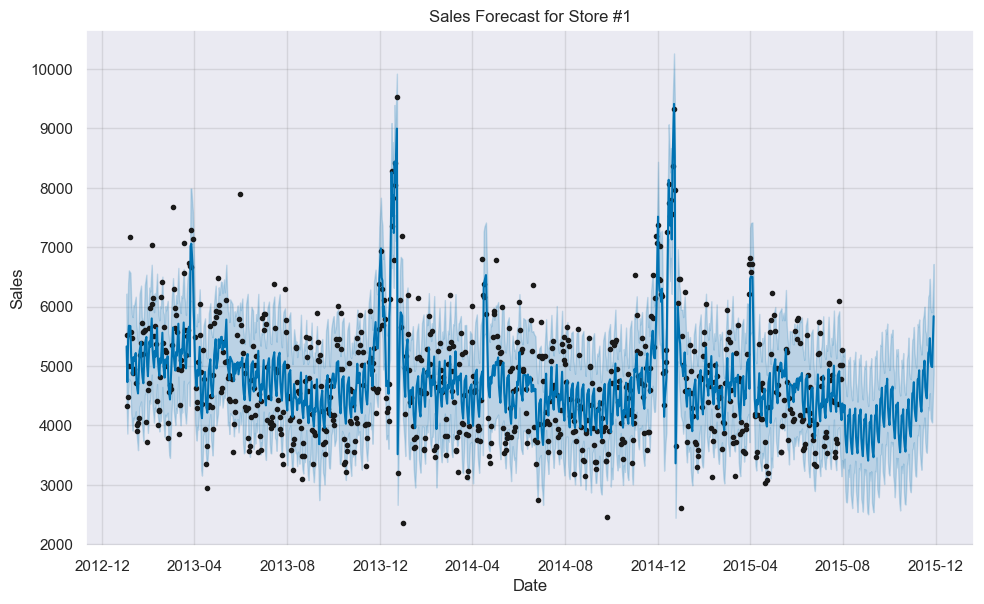

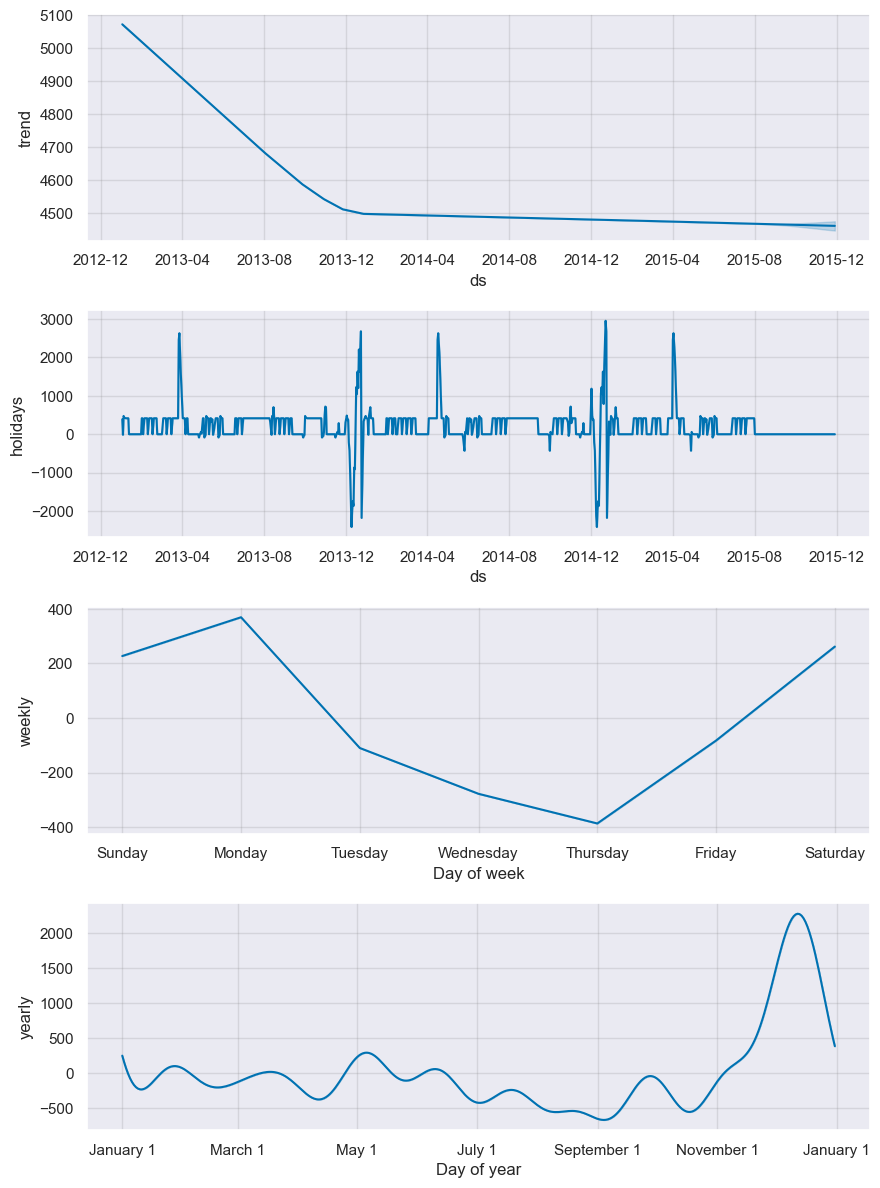

In [13]:
# Model
predictions, metrics, forecast, train, test = store_sales_predictor(Store_ID=STORE_ID, 
                                                                    df=df_sorted, 
                                                                    holidays=HOLIDAYS, 
                                                                    prediction_period=PREDICTION_PERIOD,
                                                                    n_test_splits = 3,
                                                                    test_size = 60)

## Stepwise Model Evaluation Metrics and Results

In [14]:
predictions.describe()

,ds,yhat,yhat_lower,yhat_upper,y,Residuals,Difference%,Test_Number
count,146,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000
mean,2015-04-06 19:33:41.917808128,4649.094215,3692.700573,5603.530075,4532.239726,-116.854489,15.033318,2.000000
min,2014-12-24 00:00:00,3125.790243,2086.847118,4147.424625,2605.000000,-1988.647191,0.420256,1.000000
25%,2015-02-07 12:00:00,4374.639675,3439.799390,5358.494499,3849.000000,-678.763775,5.862488,1.000000
50%,2015-04-05 12:00:00,4611.824045,3660.064248,5581.784890,4416.500000,-166.630527,10.957022,2.000000
75%,2015-06-05 18:00:00,4824.496312,3889.730625,5784.573840,5051.000000,370.260533,20.950143,3.000000
max,2015-07-18 00:00:00,6643.724240,5710.986252,7643.774573,6816.000000,1950.877180,76.339623,3.000000
std,NaN,430.949647,434.920335,433.124812,881.407936,778.850759,12.252732,0.822108


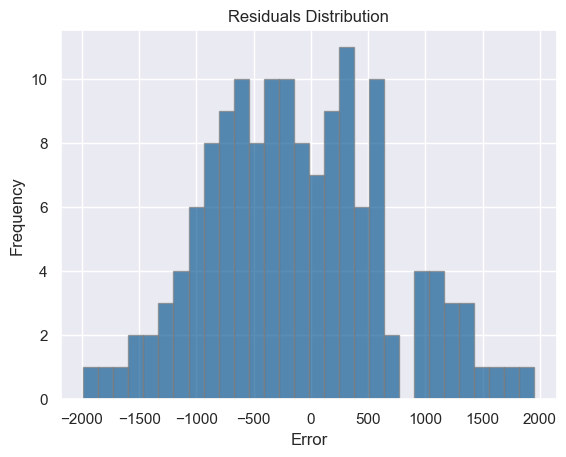

In [15]:
plt.hist(predictions['Residuals'], bins=30, color='#155E95', edgecolor='grey', alpha = 0.7)
plt.title('Residuals Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

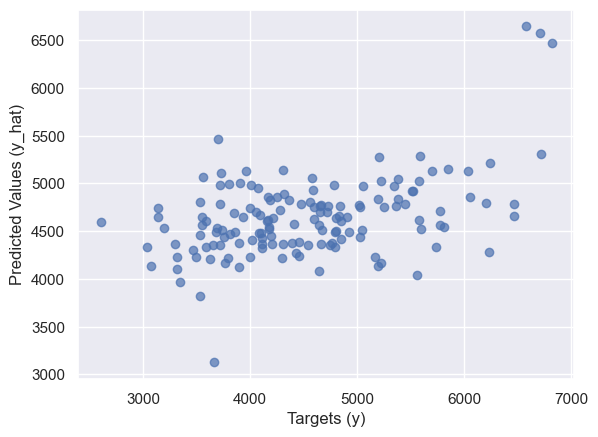

In [16]:
plt.scatter(predictions['y'], predictions['yhat'], alpha = 0.7)
plt.xlabel('Targets (y)')
plt.ylabel('Predicted Values (y_hat)')
plt.show()

In [17]:
metrics

,test_step,data_start,data_end,test_batch_size,MSE,MAE,RMSE,Store_Mean_Sales,Relative_Error%,MAPE
0,1,2014-12-24,2015-02-21,60,599926.297411,603.007358,774.549093,4759.096031,16.275131,14.065263
1,2,2015-03-07,2015-05-05,60,823311.877583,747.627302,907.365350,4759.096031,19.065918,18.260170
2,3,2015-05-21,2015-07-18,60,429316.335344,566.245756,655.222356,4759.096031,13.767790,12.840375


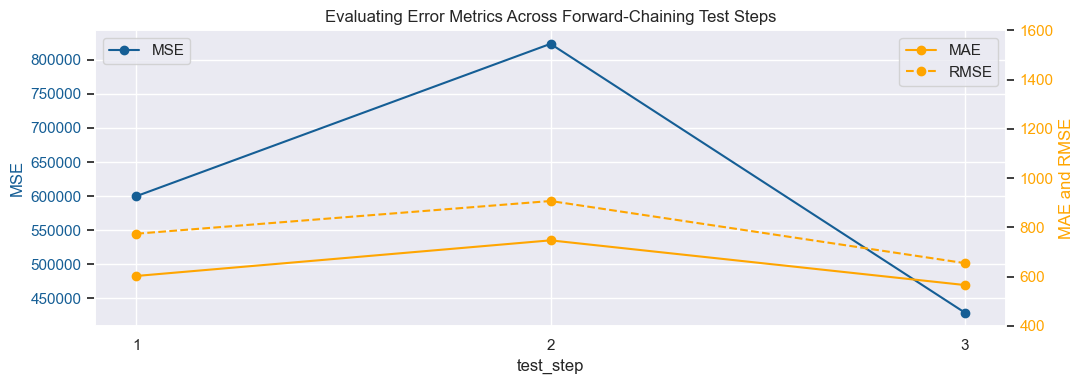

In [18]:
plot_metrics(metrics)

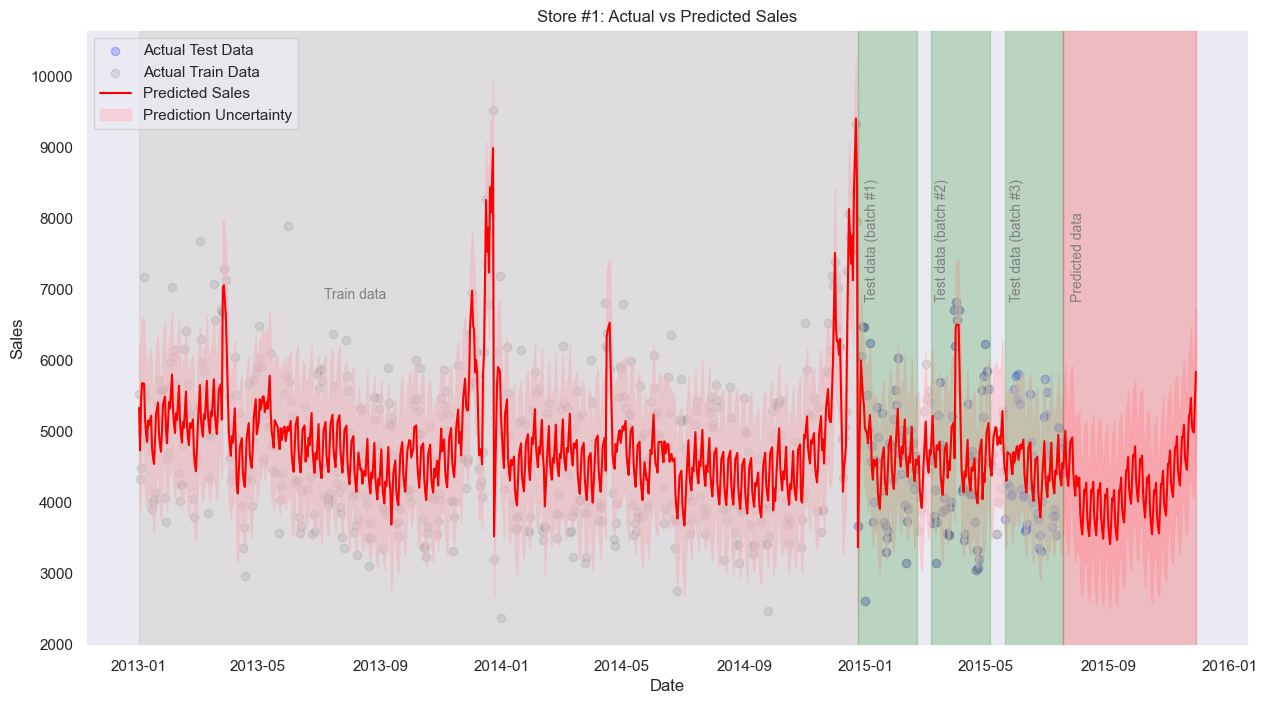

In [29]:
train_test_data_plot(predictions, forecast, STORE_ID)

In [20]:
predictions.groupby("Test_Number")['ds'].agg(['min', 'max'])

,min,max
Test_Number,,
1,2014-12-24,2015-02-21
2,2015-03-07,2015-05-05
3,2015-05-21,2015-07-18


## Hyperparameter Tuning

In [21]:
# Define parameter space for hyperparameter tuning
param_space = dict(
        growth = ['linear', 'logistic', 'flat'],
        n_changepoints = range(0, 55, 5),
        changepoint_range = uniform(0.5, 0.5),
        yearly_seasonality = [True, False],
        weekly_seasonality = [True, False],
        daily_seasonality = [True, False],
        seasonality_mode = ['additive', 'multiplicative'],
        seasonality_prior_scale = uniform(5.0, 15.0),
        changepoint_prior_scale = uniform(0.0, 0.1),
        interval_width = uniform(0.2, 0.8),
        uncertainty_samples = [500, 1000, 1500, 2000]
    )
    

# Hyperparameter tuning function
def objective_function(args_list): 
    global train, test, HOLIDAYS
    params_evaluated = []
    results = []
    
    for params in args_list:
        try:
            model = Prophet(holidays=holidays, **params)
            model.fit(train)
            future = model.make_future_dataframe(periods=len(test), freq='D')
            forecast = model.predict(future)
            predictions_tuned = forecast.tail(len(test))
            error = mape(test['y'], predictions_tuned['yhat'])   
            
            params_evaluated.append(params)
            results.append(error)
        except:
            params_evaluated.append(params)
            results.append(25.0)             # Giving high loss for exceptions regions of spaces
        
    return params_evaluated, results

In [22]:
conf_Dict = dict()
conf_Dict['initial_random'] = 10
conf_Dict['num_iteration'] = 50

tuner = Tuner(param_space, objective_function, conf_Dict)
results = tuner.minimize()
print('best parameters:', results['best_params'])
print('best loss:', results['best_objective'])

  0%|          | 0/50 [00:00<?, ?it/s]

best parameters: {'changepoint_prior_scale': 0.06508860420492078, 'changepoint_range': 0.9444982409340852, 'daily_seasonality': True, 'growth': 'flat', 'interval_width': 0.9825535678791246, 'n_changepoints': 20, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 9.729700467306781, 'uncertainty_samples': 1000, 'weekly_seasonality': True, 'yearly_seasonality': True}
best loss: 25.0


In [23]:
best_parameters = results['best_params']
best_parameters['growth'] = 'linear'

17:42:41 - cmdstanpy - INFO - Chain [1] start processing
17:42:41 - cmdstanpy - INFO - Chain [1] done processing
17:42:42 - cmdstanpy - INFO - Chain [1] start processing
17:42:42 - cmdstanpy - INFO - Chain [1] done processing
17:42:42 - cmdstanpy - INFO - Chain [1] start processing
17:42:42 - cmdstanpy - INFO - Chain [1] done processing
17:42:42 - cmdstanpy - INFO - Chain [1] start processing
17:42:43 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1400x800 with 0 Axes>

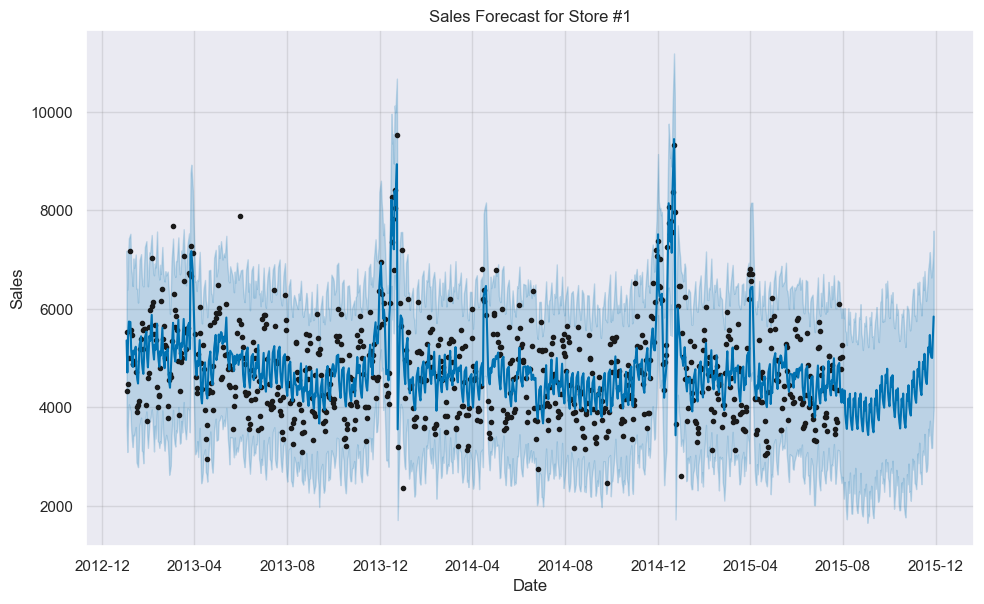

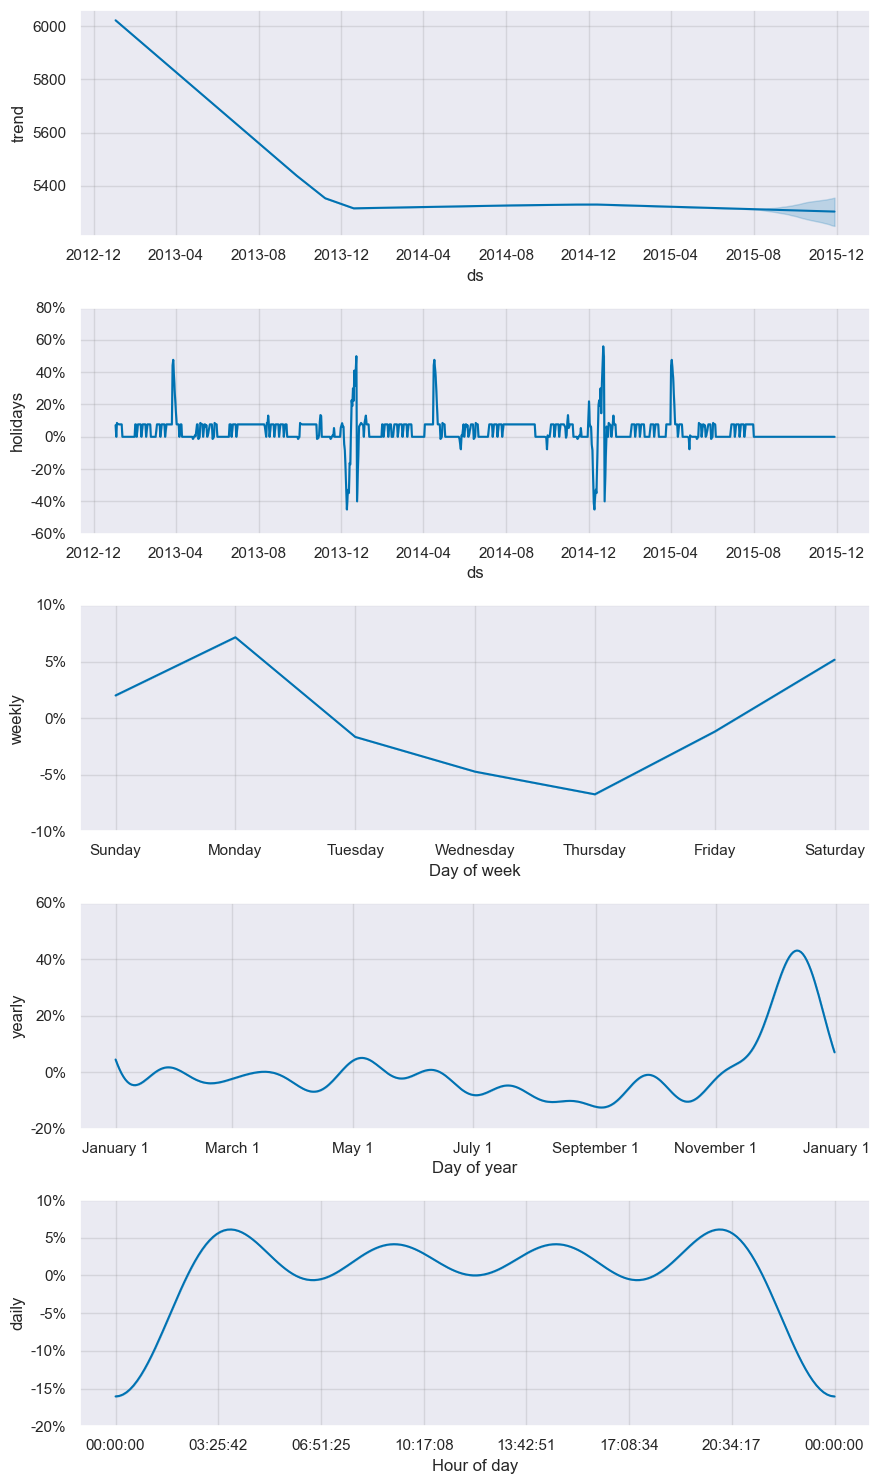

In [24]:
best_predictions, best_metrics, best_forecast, best_train, best_test  = store_sales_predictor(Store_ID=STORE_ID, 
                                                                                             df=df_sorted, holidays=HOLIDAYS, 
                                                                                             prediction_period=PREDICTION_PERIOD,
                                                                                             **best_parameters)

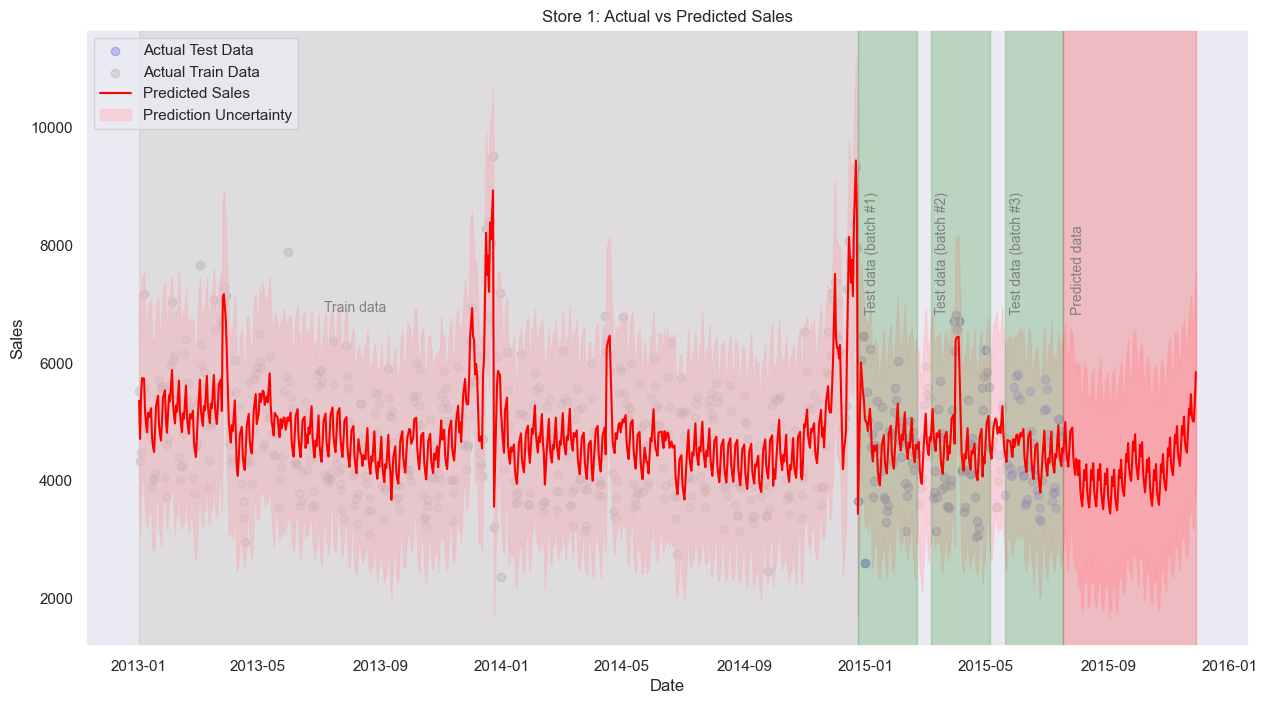

In [25]:
train_test_data_plot(best_predictions, best_forecast, STORE_ID)

In [26]:
best_metrics

,test_step,data_start,data_end,test_batch_size,MSE,MAE,RMSE,Store_Mean_Sales,Relative_Error%,MAPE
0,1,2014-12-24,2015-02-21,60,632873.190383,603.562601,795.533274,4759.096031,16.716058,15.154144
1,2,2015-03-07,2015-05-05,60,824500.952188,749.978103,908.020348,4759.096031,19.079681,18.292631
2,3,2015-05-21,2015-07-18,60,430044.978017,569.284174,655.778147,4759.096031,13.779469,12.965632


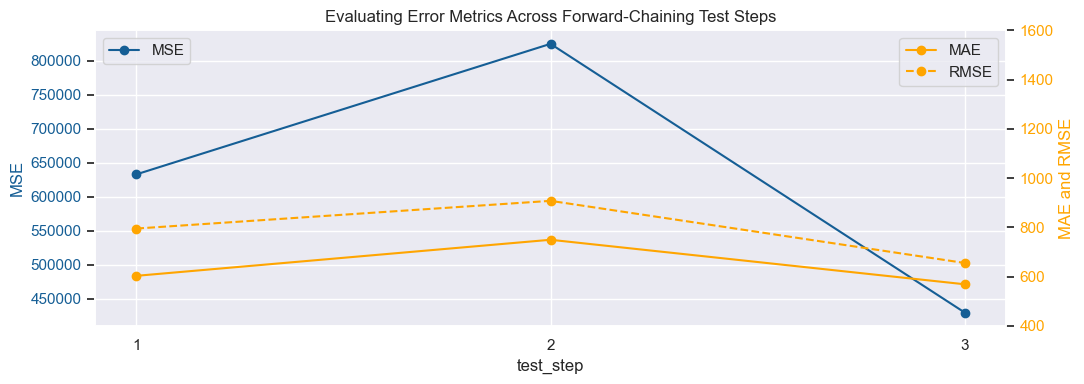

In [30]:
plot_metrics(best_metrics)

In [27]:
best_predictions.describe()

,ds,yhat,yhat_lower,yhat_upper,y,Residuals,Difference%,Test_Number
count,146,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000
mean,2015-04-06 19:33:41.917808128,4753.236671,3037.819082,6461.010211,4532.239726,-220.996945,15.451474,2.000000
min,2014-12-24 00:00:00,3360.905578,1568.366578,5226.631917,2605.000000,-2689.320930,0.072719,1.000000
25%,2015-02-07 12:00:00,4443.831649,2739.033509,6184.810447,3849.000000,-729.510292,6.296369,1.000000
50%,2015-04-05 12:00:00,4715.291455,3002.199857,6398.548435,4416.500000,-280.191656,11.058788,2.000000
75%,2015-06-05 18:00:00,4987.004991,3237.754412,6716.539806,5051.000000,293.890861,21.921618,3.000000
max,2015-07-18 00:00:00,6550.825166,4915.202234,8254.794496,6816.000000,1952.314881,103.236888,3.000000
std,NaN,475.546571,477.808884,467.936804,881.407936,763.514772,13.808353,0.822108
